In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point
from geopy.distance import geodesic
from pyproj import Transformer
from io import StringIO
from PIL import Image

### General Functions

In [2]:
transformer = Transformer.from_crs(f'EPSG:{3111}', f'EPSG:{4326}', always_xy=True)

def transform_point(point):
    lon, lat = transformer.transform(point.x, point.y)
    return Point(lon, lat)


def calculate_point(point, distance, direction):
    nw_point = geodesic(meters=distance).destination((point.y, point.x), direction)
    return Point(nw_point.longitude, nw_point.latitude)

In [3]:
OCCUPATION_CSV_HEADER_LINE = 10
OCCUPATION_CSV_CONTENT_START_LINE = 12
OCCUPATION_CSV_CONTENT_END_LINE = 42

def convert_csv_string_to_df(csv_string):
    df = pd.read_csv(StringIO(csv_string))
    return df

def format_occupation_csv(file_path):
    file = open(file_path)
    lines = file.readlines()
    header = lines[OCCUPATION_CSV_HEADER_LINE - 1]
    content = ''.join(lines[OCCUPATION_CSV_CONTENT_START_LINE - 1: OCCUPATION_CSV_CONTENT_END_LINE])
    return convert_csv_string_to_df(header + content)

### LGA Data

In [4]:
lga = gpd.read_file('../General_Data/ABS geojson/Melbourne_LGAs_2023.geojson')

In [5]:
lga['centre_point'] = lga.centroid
lga = lga.to_crs(epsg=4326)
lga['centre_point'] = lga['centre_point'].apply(transform_point)
lga['name_location'] = lga['centre_point'].apply(lambda x: calculate_point(x, 2500, 280))

C:\Users\sayan\AppData\Local\Temp\ipykernel_23420\429290745.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lga['centre_point'] = lga.centroid


In [6]:
lga['LGA_NAME23'] = lga['LGA_NAME23'].map(lambda x: x.strip(' (Vic.)'))

In [7]:
lga_population = pd.read_csv('Data/Greater Melbourne LGA Population.csv')

lga_population.rename(columns={'Local government area': 'LGA_NAME23'}, inplace=True)
lga = gpd.GeoDataFrame(pd.merge(lga, lga_population, how='left'))

### Occupation Data

In [8]:
# read the  PURP (place of usual residence) and POW (place of work) data
nw_purp_file_path = 'Data/Greater Melbourne LGA (PURP) by 4-digit level OCCP Occupation.csv'
nw_pow_file_path = 'Data/Greater Melbourne LGA (POW) by 4-digit level OCCP Occupation.csv'

nw_purp_df = format_occupation_csv(nw_purp_file_path)
nw_pow_df = format_occupation_csv(nw_pow_file_path)

In [9]:
# change the LGA name to something simpler i.e. same as the name in LGA geojson, to help in joining later
nw_purp_df.rename(columns={'4-digit level OCCP Occupation': 'LGA_NAME23'}, inplace=True)
nw_pow_df.rename(columns={'4-digit level OCCP Occupation': 'LGA_NAME23'}, inplace=True)

In [10]:
# remove ' (Vic.)' from LGA names
nw_purp_df['LGA_NAME23'] = nw_purp_df['LGA_NAME23'].map(lambda x: x.strip(' (Vic.)'))
nw_pow_df['LGA_NAME23'] = nw_pow_df['LGA_NAME23'].map(lambda x: x.strip(' (Vic.)'))

In [11]:
#change LGA name from 'Moreland' to 'Merri-bek'
nw_purp_df['LGA_NAME23'].replace('Moreland', 'Merri-bek', inplace=True)
nw_pow_df['LGA_NAME23'].replace('Moreland', 'Merri-bek', inplace=True)

In [12]:
nw_purp_gdf = gpd.GeoDataFrame(pd.merge(nw_purp_df, lga))
nw_pow_gdf = gpd.GeoDataFrame(pd.merge(nw_pow_df, lga))

In [13]:
# combine the data from 2 datasets
common_columns = ['LGA_NAME23', 'LGA_CODE23', 'AREASQKM', 'Population', 'Pop. density', 'centre_point', 'geometry']
nw_combined_gdf = nw_purp_gdf[common_columns].copy()
nw_combined_gdf['Total_POW'] = nw_pow_gdf['Total']
nw_combined_gdf['Total_PURP'] = nw_purp_gdf['Total']
nw_combined_gdf['Total Diff'] = nw_combined_gdf['Total_POW'] - nw_combined_gdf['Total_PURP']

In [14]:
# calculate night workers density
nw_combined_gdf['Total_PURP per Area'] = nw_combined_gdf['Total_PURP'] / nw_combined_gdf['AREASQKM']
nw_combined_gdf['Total_POW per Area'] = nw_combined_gdf['Total_POW'] / nw_combined_gdf['AREASQKM']
nw_combined_gdf['Total Diff per Area'] = nw_combined_gdf['Total_POW per Area'] - nw_combined_gdf['Total_PURP per Area']

In [15]:
# calculate night workers to population ratio
nw_combined_gdf['Total_PURP per Population'] = nw_combined_gdf['Total_PURP'] / nw_combined_gdf['Population']
nw_combined_gdf['Total_POW per Population'] = nw_combined_gdf['Total_POW'] / nw_combined_gdf['Population']
nw_combined_gdf['Total Diff per Population'] = nw_combined_gdf['Total_POW per Population'] - nw_combined_gdf['Total_PURP per Population']

In [16]:
nw_combined_gdf.to_csv("./Data/MoM.Night_Workers.Combined_Data.csv", index=False)

### Map Plot

In [17]:
nw_csv_input_path = "./Data/MoM.Night_Workers.Combined_Data.csv"
df = pd.read_csv(nw_csv_input_path)
df["geometry"] = df["geometry"].apply(wkt.loads)
nw_combined_gdf = gpd.GeoDataFrame(df)

In [18]:
#missing_data_lga = set(lga['LGA_NAME23']) - set(nw_combined_gdf['LGA_NAME23'])

#### Night Workers Density per km2 (Number of workers / Land area)

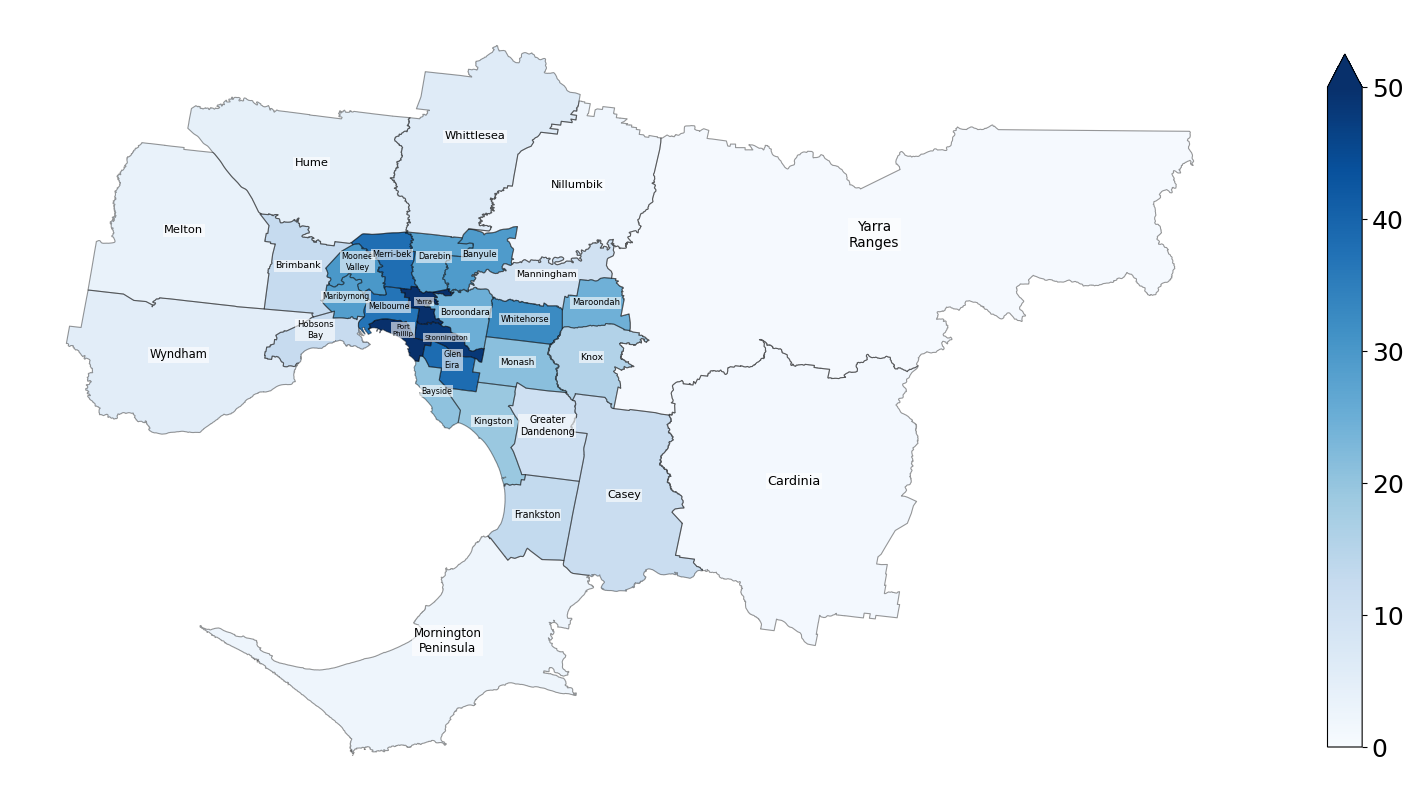

In [19]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

nw_combined_gdf.plot(ax=ax, column='Total_PURP per Area', cmap='Blues', vmin=0, vmax=50,
                     legend=True, legend_kwds={'extend':'max', 'shrink':0.45})

cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)

nw_combined_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.8, alpha=0.4)
nw_combined_gdf.apply(lambda x: ax.text(x.geometry.centroid.coords[0][0], x.geometry.centroid.coords[0][1],
                                        s='\n'.join(x['LGA_NAME23'].split()), ha='center', size=(np.log(x['AREASQKM'])+2),
                                        bbox={'facecolor': 'white', 'alpha':0.6, 'pad': 1, 'edgecolor':'none'}), axis=1)

plt.savefig("./Map files for printing/MoM.Night_workers_LGA_usual_residence_per_area_map.png", transparent=True, bbox_inches='tight')

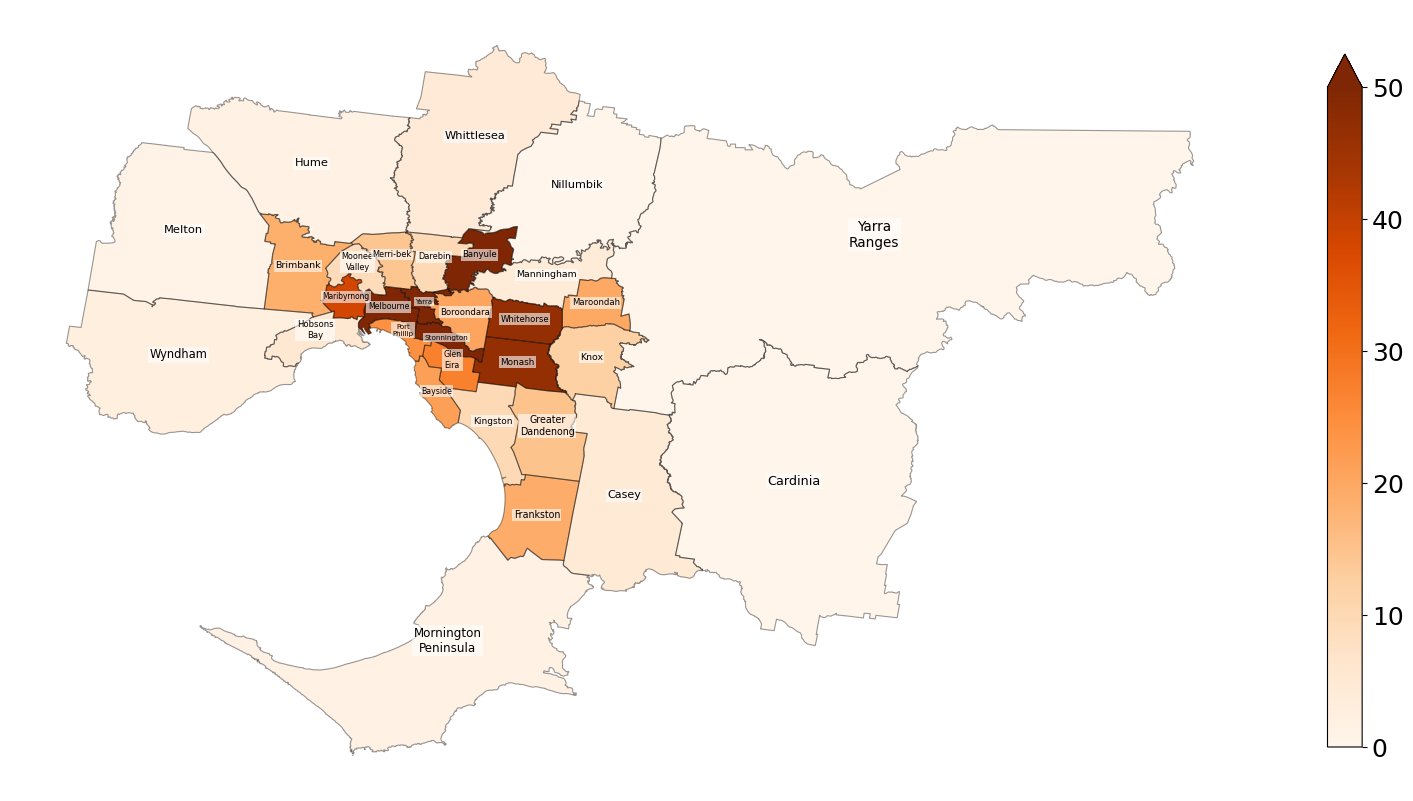

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

nw_combined_gdf.plot(ax=ax, column='Total_POW per Area', cmap='Oranges', vmin=0, vmax=50,
                     legend=True, legend_kwds={'extend':'max', 'shrink':0.45})

cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)

nw_combined_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.8, alpha=0.4)
nw_combined_gdf.apply(lambda x: ax.text(x.geometry.centroid.coords[0][0], x.geometry.centroid.coords[0][1],
                                        s='\n'.join(x['LGA_NAME23'].split()), ha='center', size=(np.log(x['AREASQKM'])+2),
                                        bbox={'facecolor': 'white', 'alpha':0.6, 'pad': 1, 'edgecolor':'none'}), axis=1)

plt.savefig("./Map files for printing/MoM.Night_workers_LGA_place_of_work_per_area_map.png", transparent=True, bbox_inches='tight')

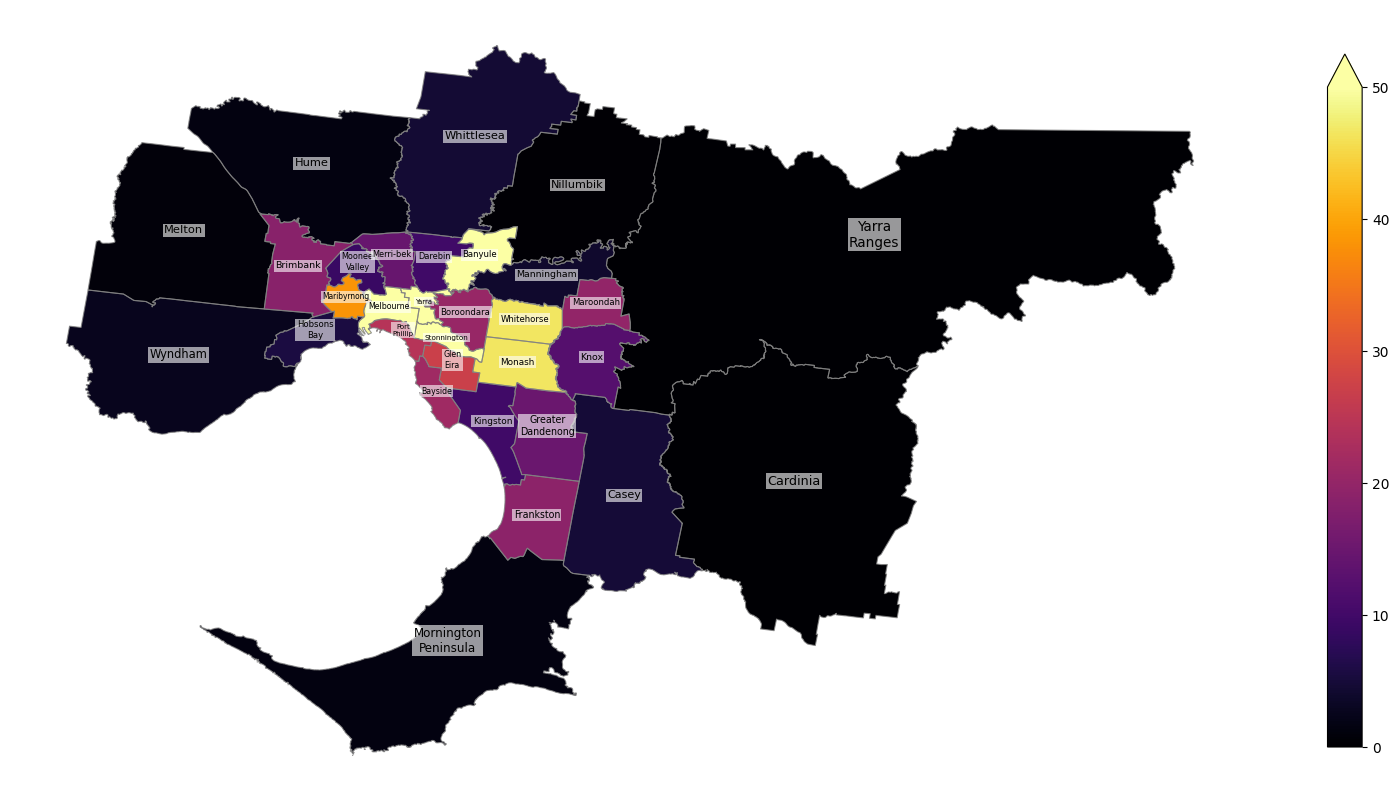

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

nw_combined_gdf.plot(ax=ax, column='Total_POW per Area', cmap='inferno', vmin=0, vmax=50,
                     legend=True, legend_kwds={'extend':'max', 'shrink':0.45})

nw_combined_gdf.plot(ax=ax, facecolor='none', edgecolor='grey', lw=0.8, alpha=0.8)
nw_combined_gdf.apply(lambda x: ax.text(x.geometry.centroid.coords[0][0], x.geometry.centroid.coords[0][1],
                                        s='\n'.join(x['LGA_NAME23'].split()), ha='center', size=(np.log(x['AREASQKM'])+2),
                                        bbox={'facecolor': 'white', 'alpha':0.6, 'pad': 1, 'edgecolor':'none'}), axis=1)

plt.savefig("./Map files for printing/MoM.Night_workers_LGA_place_of_work_per_area_map.inferno.png", transparent=True)

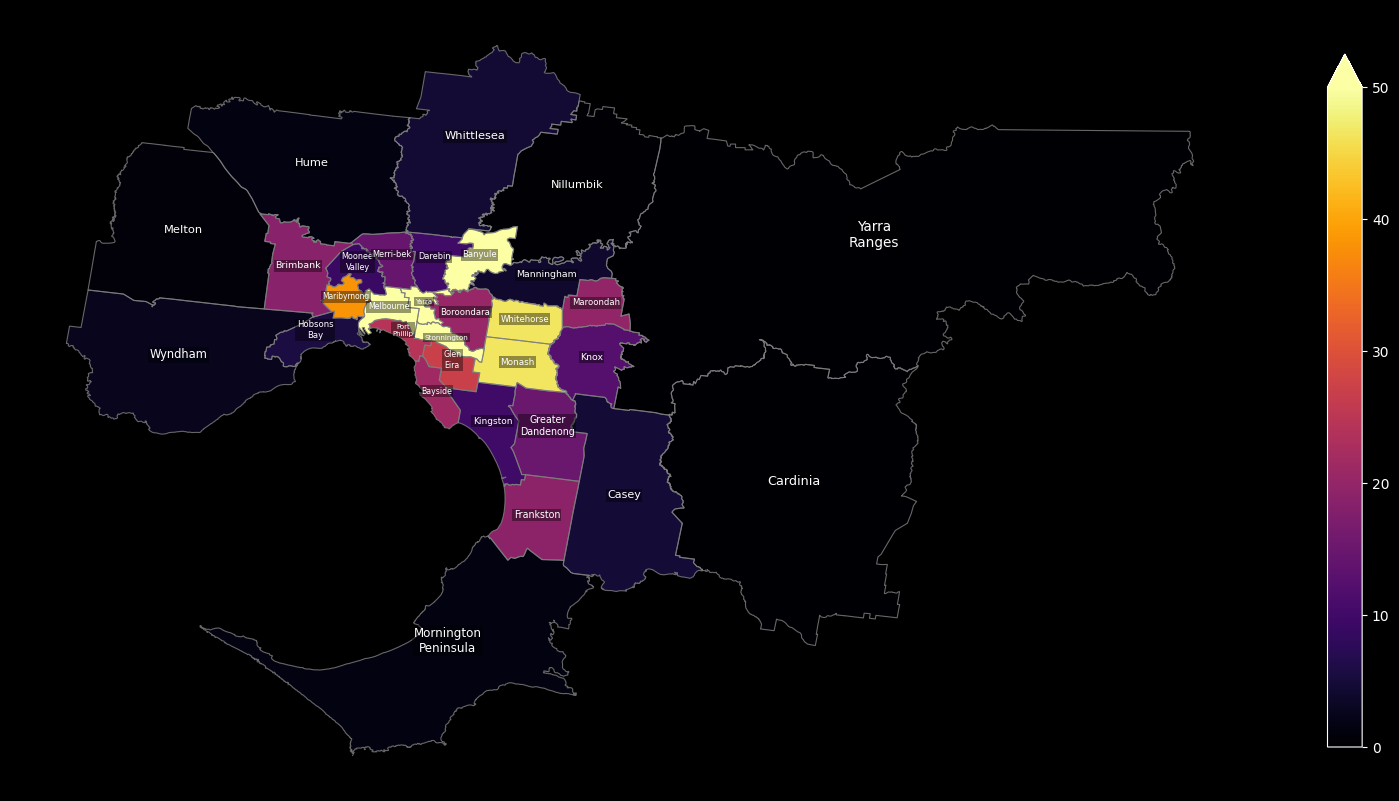

In [22]:
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

nw_combined_gdf.plot(ax=ax, column='Total_POW per Area', cmap='inferno', vmin=0, vmax=50,
                     legend=True, legend_kwds={'extend':'max', 'shrink':0.45})

nw_combined_gdf.plot(ax=ax, facecolor='none', edgecolor='grey', lw=0.8, alpha=0.8)
nw_combined_gdf.apply(lambda x: ax.text(x.geometry.centroid.coords[0][0], x.geometry.centroid.coords[0][1],
                                        s='\n'.join(x['LGA_NAME23'].split()), ha='center', size=(np.log(x['AREASQKM'])+2),
                                        bbox={'facecolor': 'black', 'alpha':0.4, 'pad': 1, 'edgecolor':'none'}), axis=1)

if os.path.exists('Data/moon.png'):
    moon_image = Image.open('Data/moon.png')
    moon_image = moon_image.resize((200, 200))
    fig.figimage(moon_image, xo=1490, yo=1400, alpha=0.3)

plt.savefig("./Map files for printing/MoM.Night_workers_LGA_place_of_work_per_area_map.dark.png")

plt.style.use('default')

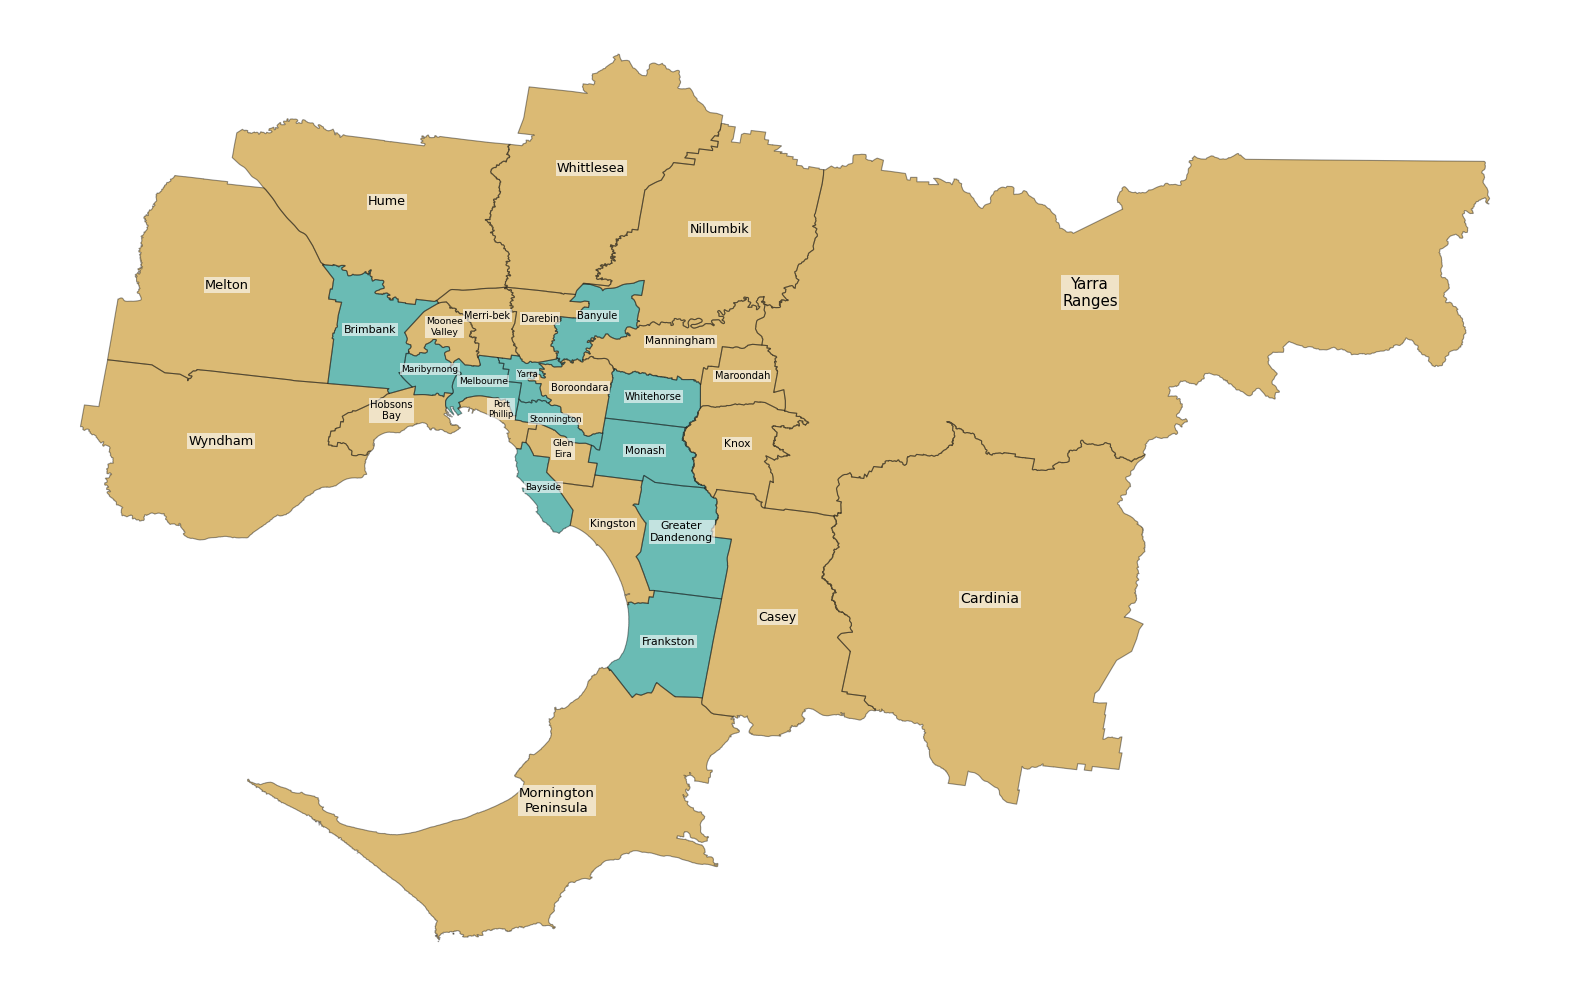

In [23]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

nw_combined_gdf.plot(ax=ax, color=np.where(nw_combined_gdf['Total Diff per Area'] > 0, '#5ab4ac', '#d8b365'), alpha=0.9,
                     legend=True, legend_kwds={'extend':'max', 'shrink':0.5})

nw_combined_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.8, alpha=0.4)
nw_combined_gdf.apply(lambda x: ax.text(x.geometry.centroid.coords[0][0], x.geometry.centroid.coords[0][1],
                                        s='\n'.join(x['LGA_NAME23'].split()), ha='center', size=(np.log(x['AREASQKM'])+3),
                                        bbox={'facecolor': 'white', 'alpha':0.6, 'pad': 1, 'edgecolor':'none'}), axis=1)

plt.savefig("./Map files for printing/MoM.Night_workers_LGA_combined_map.png", transparent=True, bbox_inches='tight')

#### Night Workers to Population ratio (Number of workers / Land population)

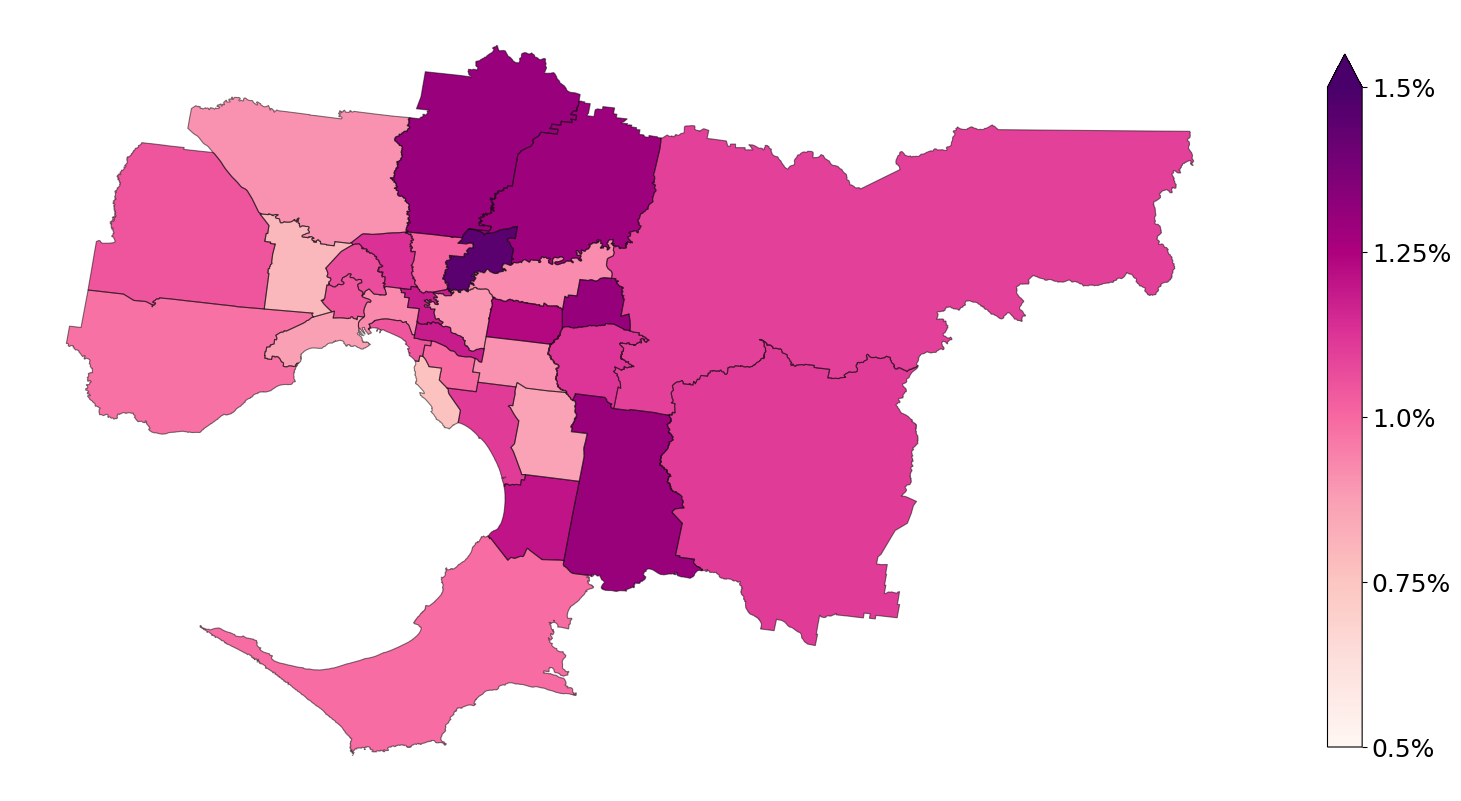

In [24]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

nw_combined_gdf.plot(ax=ax, column='Total_PURP per Population', cmap='RdPu', vmin=0.005, vmax=0.015,
                     legend=True, legend_kwds={'extend':'max', 'shrink':0.45})

cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)

ticks = [0.005, 0.0075, 0.01, 0.0125, 0.015]
ticklabels = [str(tick * 100.0) + '%' for tick in ticks]
cb_ax.set_yticks(ticks)
cb_ax.set_yticklabels(ticklabels)

nw_combined_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.8, alpha=0.5)

plt.savefig("./Map files for printing/MoM.Night_workers_LGA_usual_residence_per_population_map.png", transparent=True, bbox_inches='tight')

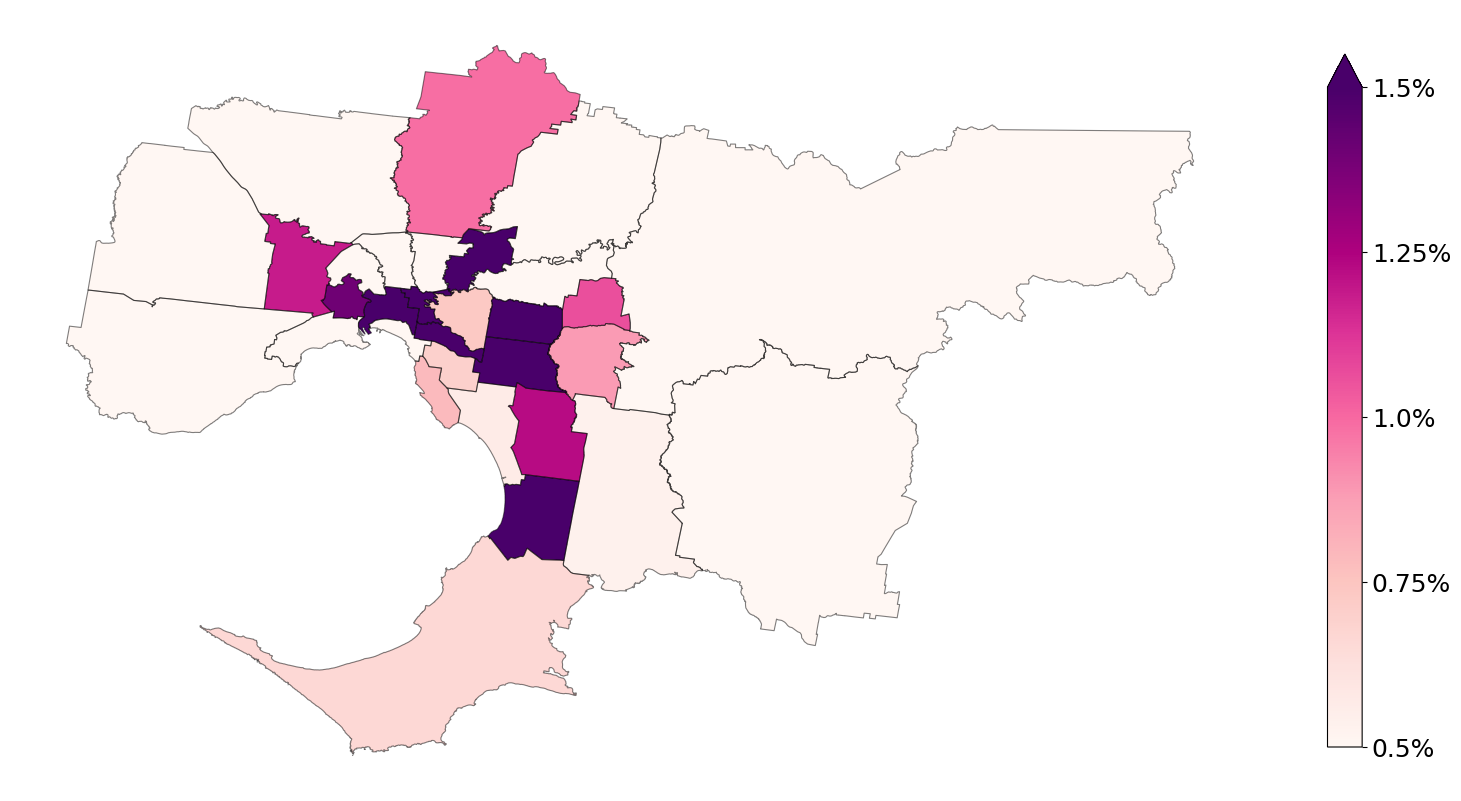

In [25]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

nw_combined_gdf.plot(ax=ax, column='Total_POW per Population', cmap='RdPu', vmin=0.005, vmax=0.015,
                     legend=True, legend_kwds={'extend':'max', 'shrink':0.45})

cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)

ticks = [0.005, 0.0075, 0.01, 0.0125, 0.015]
ticklabels = [str(tick * 100.0) + '%' for tick in ticks]
cb_ax.set_yticks(ticks)
cb_ax.set_yticklabels(ticklabels)

nw_combined_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.8, alpha=0.5)

plt.savefig("./Map files for printing/MoM.Night_workers_LGA_place_of_work_per_population_map.png", transparent=True, bbox_inches='tight')

#### Night Workers Total (Numer of workers)

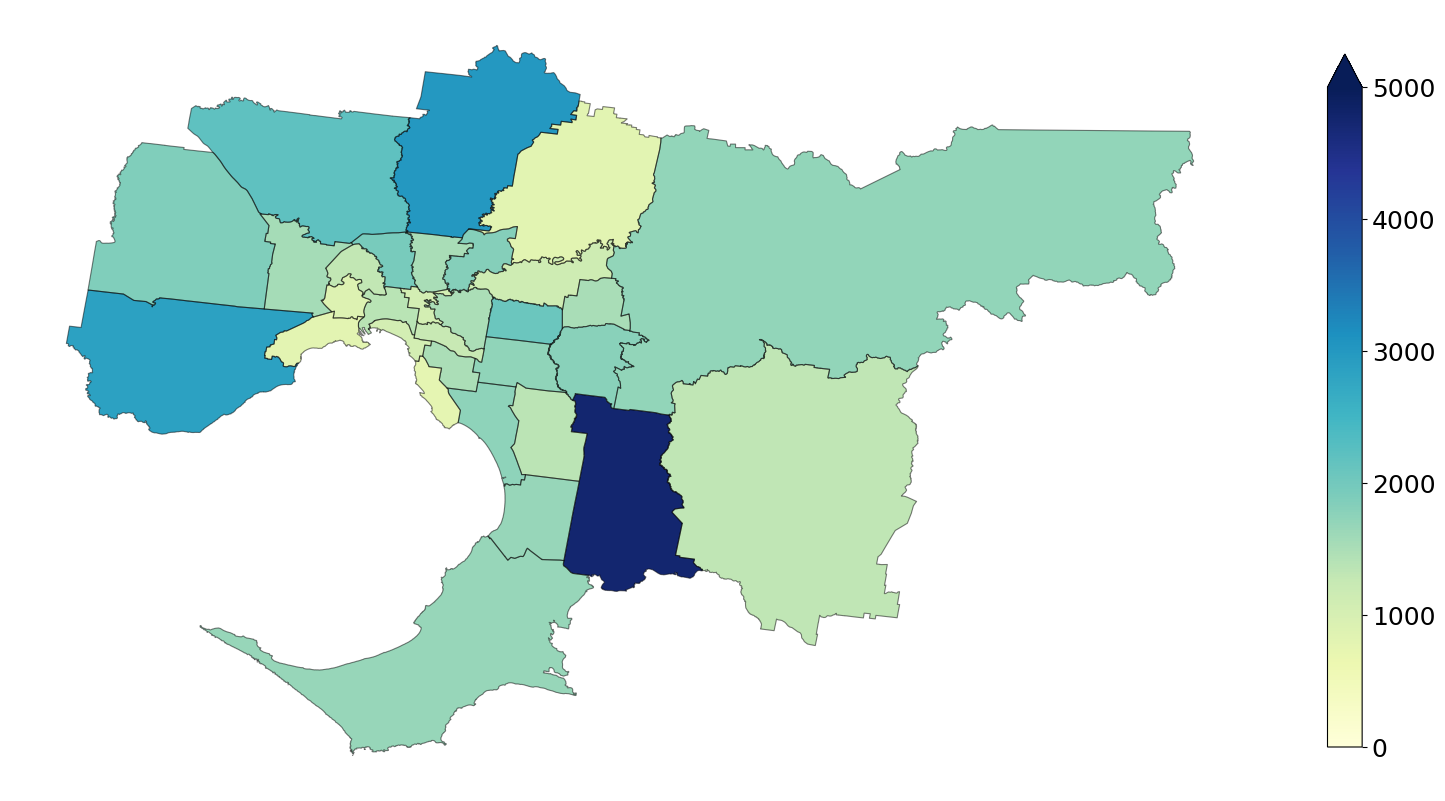

In [26]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

nw_combined_gdf.plot(ax=ax, column='Total_PURP', cmap='YlGnBu', vmin=0, vmax=5000,
                     legend=True, legend_kwds={'extend':'max', 'shrink':0.45})

cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)

nw_combined_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.8, alpha=0.5)

plt.savefig("./Map files for printing/MoM.Night_workers_LGA_usual_residence_map.png", transparent=True, bbox_inches='tight')

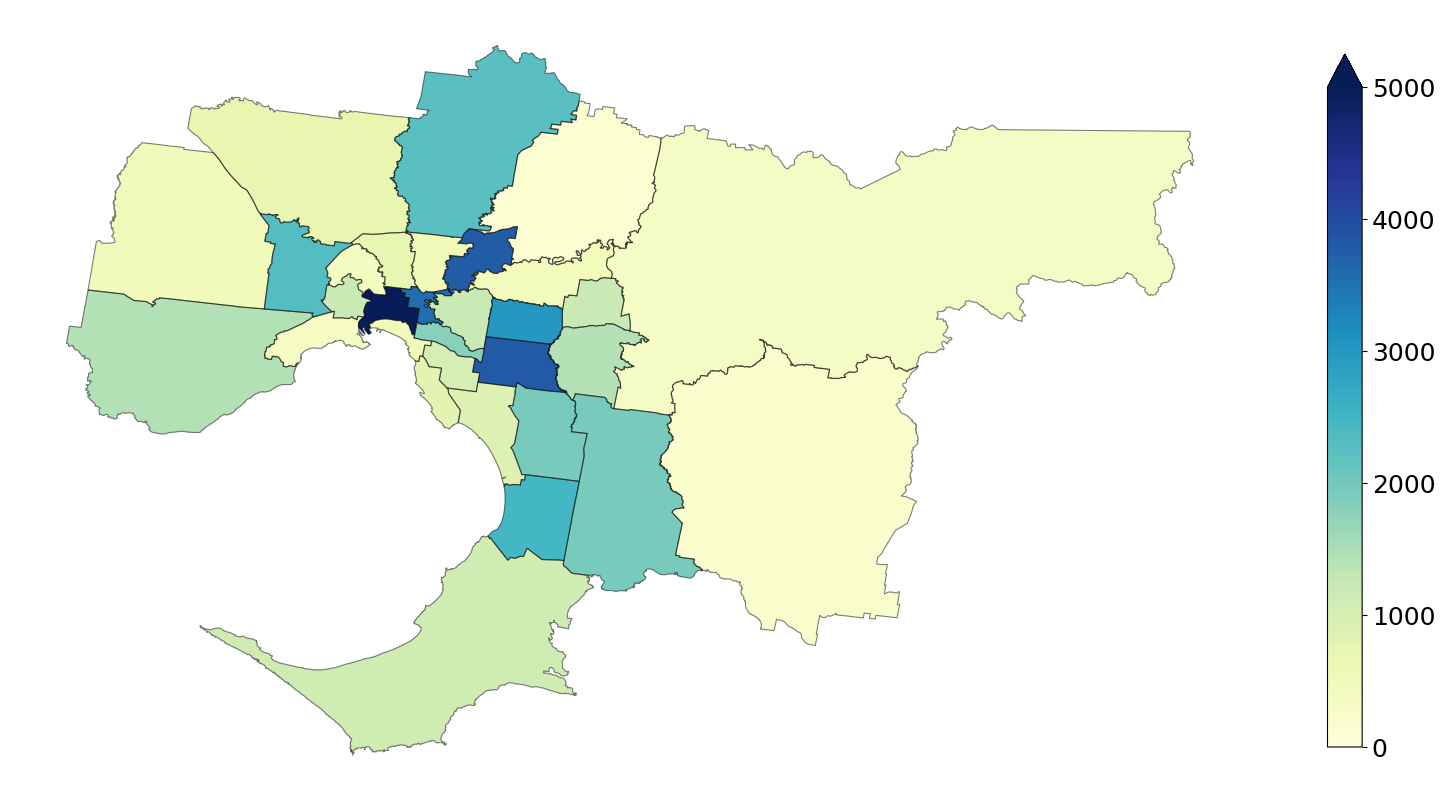

In [27]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_axis_off()

nw_combined_gdf.plot(ax=ax, column='Total_POW', cmap='YlGnBu', vmin=0, vmax=5000,
                     legend=True, legend_kwds={'extend':'max', 'shrink':0.45})

cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=18)

nw_combined_gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.8, alpha=0.5)

plt.savefig("./Map files for printing/MoM.Night_workers_LGA_place_of_work_map.png", transparent=True, bbox_inches='tight')

### Bar Chart

In [28]:
nw_combined_gdf.head(2)

,LGA_NAME23,LGA_CODE23,AREASQKM,Population,Pop. density,centre_point,geometry,Total_POW,Total_PURP,Total Diff,Total_PURP per Area,Total_POW per Area,Total Diff per Area,Total_PURP per Population,Total_POW per Population,Total Diff per Population
0,Banyule,20660,62.5402,126236.0,5354.0,POINT (107.26284159350388 -54.67198642453559),"MULTIPOLYGON (((145.08875 -37.69135, 145.08926...",3775,1831,1944,29.277169,60.361176,31.084007,0.014505,0.029904,0.015400
1,Bayside,20910,37.2111,101306.0,7400.0,POINT (107.26283948482954 -54.671987865889975),"MULTIPOLYGON (((145.02953 -37.99181, 145.02937...",798,770,28,20.692750,21.445214,0.752464,0.007601,0.007877,0.000276


In [29]:
float_columns = ['Total_PURP per Area', 
                 'Total_POW per Area', 
                 'Total Diff per Area']
nw_combined_gdf[float_columns] = nw_combined_gdf[float_columns].round(1)
nw_combined_gdf.head(2)

,LGA_NAME23,LGA_CODE23,AREASQKM,Population,Pop. density,centre_point,geometry,Total_POW,Total_PURP,Total Diff,Total_PURP per Area,Total_POW per Area,Total Diff per Area,Total_PURP per Population,Total_POW per Population,Total Diff per Population
0,Banyule,20660,62.5402,126236.0,5354.0,POINT (107.26284159350388 -54.67198642453559),"MULTIPOLYGON (((145.08875 -37.69135, 145.08926...",3775,1831,1944,29.3,60.4,31.1,0.014505,0.029904,0.015400
1,Bayside,20910,37.2111,101306.0,7400.0,POINT (107.26283948482954 -54.671987865889975),"MULTIPOLYGON (((145.02953 -37.99181, 145.02937...",798,770,28,20.7,21.4,0.8,0.007601,0.007877,0.000276


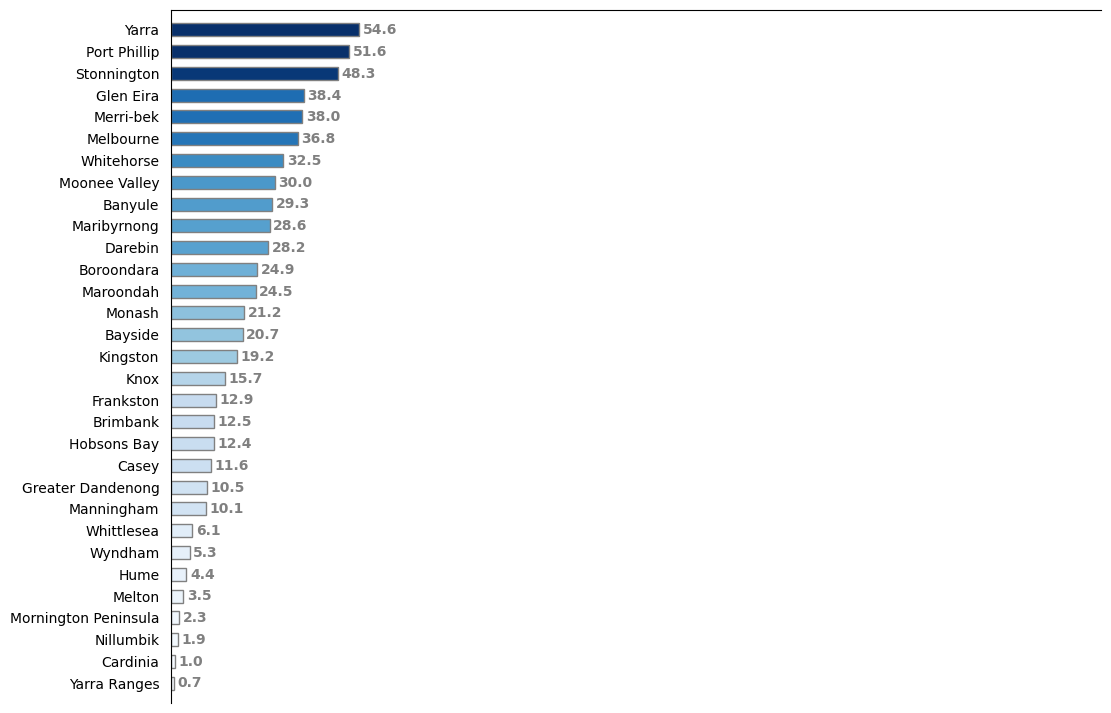

In [30]:
# PURP
nw_combined_gdf = nw_combined_gdf.sort_values(by = ['Total_PURP per Area'])
lgas = list(nw_combined_gdf['LGA_NAME23'])
values = list(nw_combined_gdf['Total_PURP per Area'])

# use the color map and rescale the values between 0 and 1
my_cmap = plt.get_cmap("Blues")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# for color map, make sure the density per km2 value is at most 50
cmap_values = [50 if value > 50 else value for value in values]

# Figure Size                 width, length
fig, ax = plt.subplots(figsize =(12, 9))
 
# creating the bar plot
ax.barh(lgas, values, color = my_cmap(rescale(cmap_values)), align='center', height=0.6, edgecolor='gray')

# Remove x, y Ticks
ax.yaxis.set_ticks_position('none')

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+1, i.get_y()+0.1, 
             str(i.get_width()),
             fontsize = 10, fontweight ='bold',
             color ='gray')
    
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)
ax.yaxis.set_tick_params(pad = 5)

# hide x axis
ax.get_xaxis().set_visible(False)
# hide right and bottom spines
ax.spines[['right', 'bottom']].set_visible(False)
# set the limit of the a axis to be 10000
ax.set_xlim(0, 270)

# adjust the margins
plt.margins(y=0.02)

# plt.ylabel("Local government areas", fontsize=10)
plt.show()

fig.savefig("./Map files for printing/MoM.Night_workers_LGA_usual_residence_barchart.png", bbox_inches = 'tight', transparent=True)

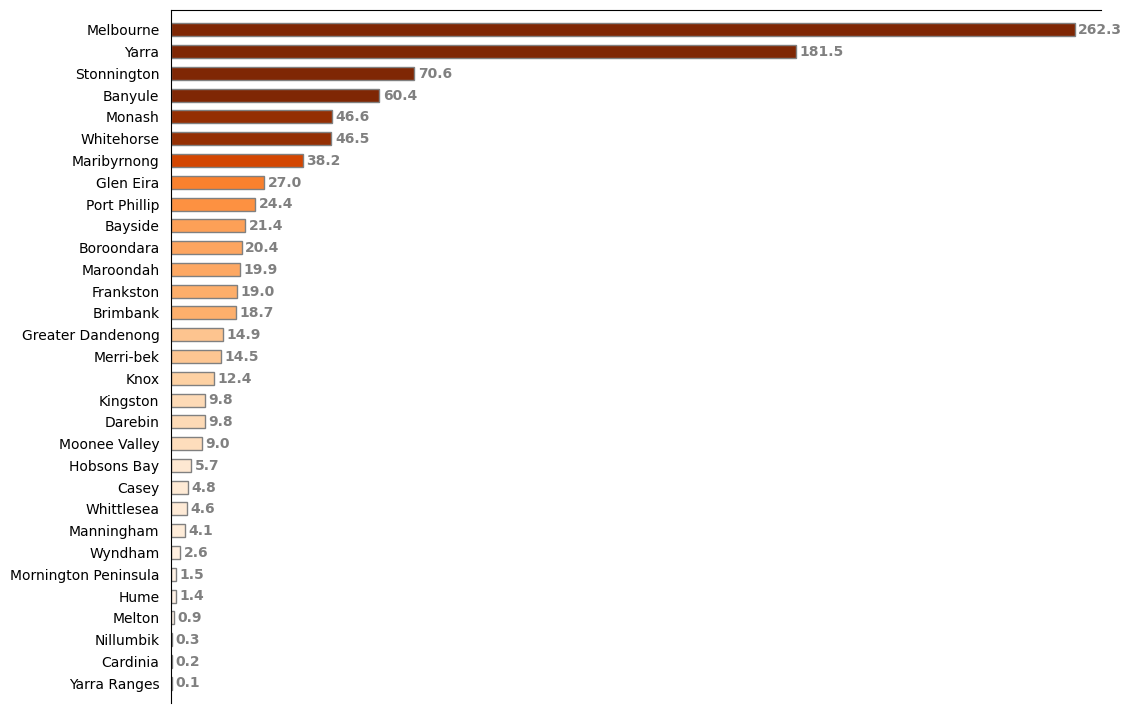

In [31]:
# POW
nw_combined_gdf = nw_combined_gdf.sort_values(by = ['Total_POW per Area'])
lgas = list(nw_combined_gdf['LGA_NAME23'])
values = list(nw_combined_gdf['Total_POW per Area'])

my_cmap = plt.get_cmap("Oranges")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# for color map, make sure the density per km2 value is at most 50
cmap_values = [50 if value > 50 else value for value in values]

# Figure Size                 width, length
fig, ax = plt.subplots(figsize =(12, 9))
 
# creating the bar plot
ax.barh(lgas, values, color = my_cmap(rescale(cmap_values)), align='center', height=0.6, edgecolor='gray')

# Remove x, y Ticks
ax.yaxis.set_ticks_position('none')

# hide x axis
ax.get_xaxis().set_visible(False)
# hide right and bottom spines
ax.spines[['right', 'bottom']].set_visible(False)
# set the limit of the a axis to be 10000
ax.set_xlim(0, 270)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+1, i.get_y()+0.1, 
             str(i.get_width()),
             fontsize = 10, fontweight ='bold',
             color ='gray')
    
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)
ax.yaxis.set_tick_params(pad = 5)

# adjust the margins
plt.margins(y=0.02)

# plt.ylabel("Local government areas", fontsize=10)
plt.show()

fig.savefig("./Map files for printing/MoM.Night_workers_LGA_place_of_work_barchart.png", bbox_inches = 'tight', transparent=True)

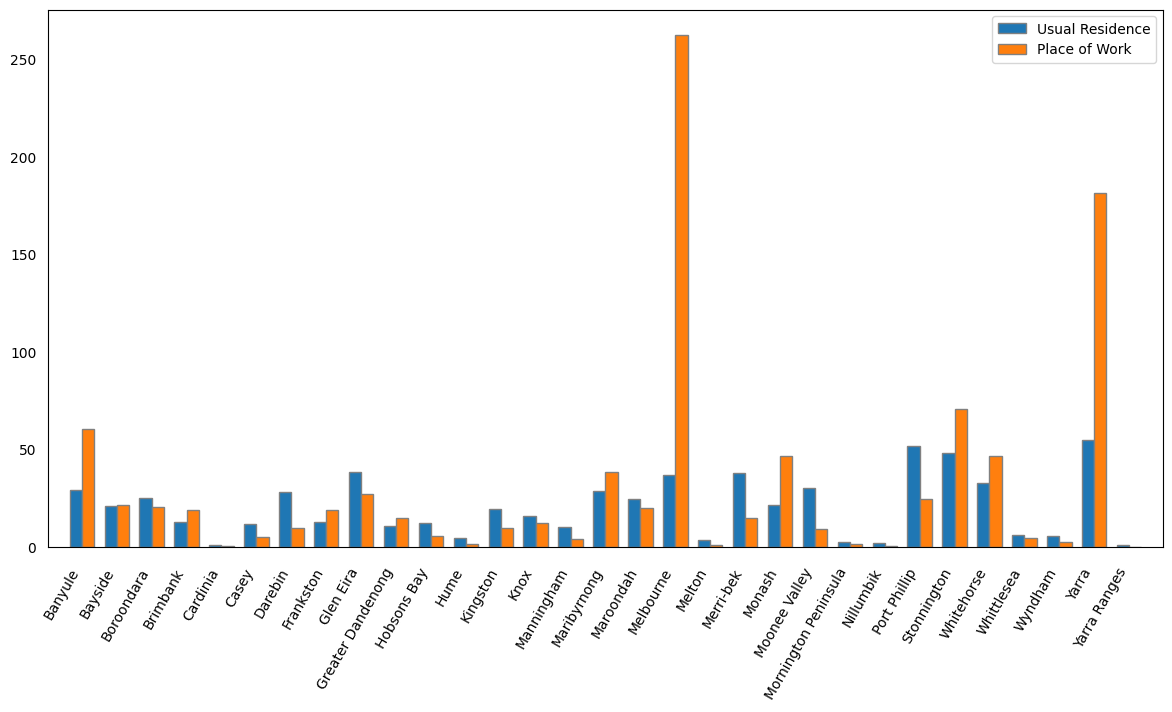

In [32]:
# grouped bar chart

# sort by lga names
nw_combined_gdf.sort_values(['LGA_NAME23'], inplace = True)
lgas = list(nw_combined_gdf['LGA_NAME23'])
purp_per_area = list(nw_combined_gdf['Total_PURP per Area'])
pow_per_area = list(nw_combined_gdf['Total_POW per Area'])
x = np.arange(len(lgas))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, purp_per_area, width, label='Usual Residence', edgecolor='gray')
rects2 = ax.bar(x + width/2, pow_per_area, width, label='Place of Work', edgecolor='gray')

ax.set_xticks(x)
ax.set_xticklabels(lgas)
ax.legend()

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 10)
ax.yaxis.set_tick_params(pad = 5)

# adjust the margins
plt.margins(x=0.02)

fig.tight_layout()
plt.xticks(rotation=60, ha='right')
plt.show()

# save he image without cropping it
fig.savefig("./Map files for printing/MoM.Night_workers_LGA_place_of_work_grouped_barchart2.png", bbox_inches = 'tight', transparent=True)

In [33]:
def color_fun(difference):
    lst = []
    for i in difference:
        lst.append('#5ab4ac' if i > 0 else '#d8b365') 
    return lst

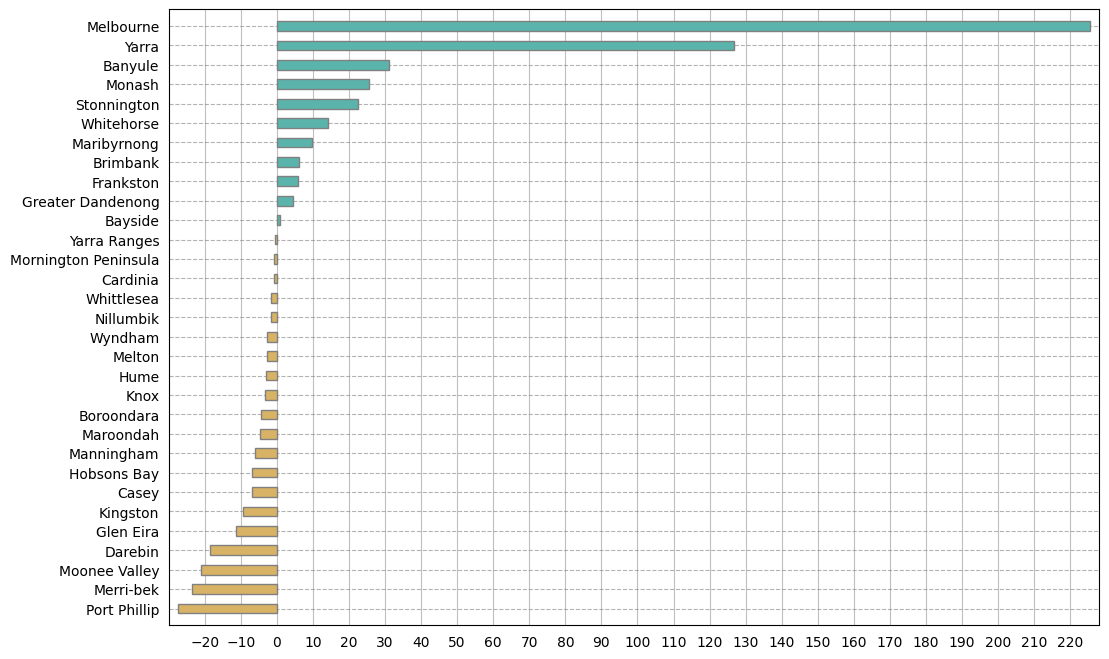

In [34]:
nw_combined_gdf.sort_values(['Total Diff per Area'], inplace = True)
difference = list(nw_combined_gdf['Total Diff per Area'])
lgas = list(nw_combined_gdf['LGA_NAME23'])

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(lgas, difference, align='center', height=0.5, color=color_fun(difference), zorder=2, edgecolor='gray')

# adding grid lines for the count axis and maybe tick marks for the axis labels.
ax.grid(axis='y', linestyle='dashed', alpha=0.6, color='gray')
ax.grid(axis='x', alpha=0.8)

# add more xticks
plt.xticks(np.arange(-20, 230, 10))

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
plt.margins(x=0.01, y=0.02)

fig.savefig("./Map files for printing/MoM.Night_workers_difference_barchart.png", bbox_inches = 'tight', transparent=True)